### Importing libraries and settings

In [13]:
# project tools:
from tools import *

# built-in libraries:
import math
from collections import defaultdict

# data wrangling libraries:
import numpy as np
import pandas as pd

# Ploting libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# text manipulation libraries:
import textstat
import nltk
from nltk.corpus import stopwords

# xgboost model library:
from xgboost import XGBRegressor

# sklearn pre-train methods:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# sklearn models:
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# sklearn pipelines and metrics:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

In [14]:
def add_creative_features(dataframe):
    dataframe['num_punct_marks'] = dataframe['excerpt'].apply(num_punct_marks)
    dataframe['num_uniq_words'] = dataframe['excerpt'].apply(num_unique_words)
    dataframe['rarity'] = dataframe['excerpt'].apply(rarity)


def add_clasic_test(dataframe):
    clasical_complexity_tests = {'fre_test': textstat.flesch_reading_ease,
                                 'fkg_test': textstat.flesch_kincaid_grade,
                                 'gf_test': textstat.gunning_fog,
                                 'si_test': textstat.smog_index,
                                 'dcrs_test': textstat.dale_chall_readability_score}

    # Creating text complexity feature for every test:
    for test in clasical_complexity_tests.keys():
        test_func = clasical_complexity_tests[test]

        dataframe[test] = dataframe['excerpt'].apply(lambda value: test_func(value))

### Creating clasic text complexity features to the train dataset:

In [15]:
train = pd.read_csv('train.csv', usecols=['id', 'excerpt', 'target'])

In [16]:
add_creative_features(train)
add_clasic_test(train)

In [18]:
X_train = train['excerpt']
y_train = train['target']

### Let's add ridge regression component

In [22]:
model = Ridge()

pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('rgr', model)])
pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_train)
train['ridge_pred'] = preds

### Awesome! Now that the clasic test are added now we can check for patterns in the data... But first let's split the data sets again:

In [23]:
# Descriptive statistics of the features:
train.describe()

,target,num_punct_marks,num_uniq_words,rarity,fre_test,fkg_test,gf_test,si_test,dcrs_test,ridge_pred
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,-0.956532,23.546337,106.172109,79125.353045,67.911006,9.575640,11.684559,10.342101,6.708539,-0.956532
std,1.034396,6.287295,12.980897,34471.146012,17.550160,4.409224,4.520979,3.285387,1.939876,0.749590
min,-3.676268,8.000000,37.000000,10575.000000,-22.930000,-0.900000,2.040000,0.000000,0.400000,-2.909102
25%,-1.684175,19.000000,97.000000,52460.500000,57.710000,6.700000,8.760000,8.100000,6.080000,-1.513208
50%,-0.924614,23.000000,106.000000,77229.000000,69.010000,9.200000,11.160000,10.300000,6.970000,-0.931540
75%,-0.202540,27.000000,115.000000,101976.250000,80.310000,11.800000,13.890000,12.500000,7.820000,-0.409758
max,1.711390,51.000000,142.000000,214106.000000,114.520000,39.700000,44.300000,22.900000,12.580000,1.041750


In [24]:
# Correlation between the features:
correlations = train.corr()
correlations

,target,num_punct_marks,num_uniq_words,rarity,fre_test,fkg_test,gf_test,si_test,dcrs_test,ridge_pred
target,1.000000,0.076215,-0.228727,0.462073,0.529439,-0.459154,-0.462850,-0.538326,-0.552461,0.939914
num_punct_marks,0.076215,1.000000,0.249035,0.105540,0.247136,-0.258086,-0.258744,-0.231906,-0.230029,0.170419
num_uniq_words,-0.228727,0.249035,1.000000,0.104855,-0.104917,0.136103,0.158447,0.101386,0.212836,-0.188031
rarity,0.462073,0.105540,0.104855,1.000000,0.510041,-0.327877,-0.299265,-0.521054,-0.539339,0.575233
fre_test,0.529439,0.247136,-0.104917,0.510041,1.000000,-0.893418,-0.838741,-0.793886,-0.785613,0.613914
fkg_test,-0.459154,-0.258086,0.136103,-0.327877,-0.893418,1.000000,0.982965,0.581151,0.635690,-0.522223
gf_test,-0.462850,-0.258744,0.158447,-0.299265,-0.838741,0.982965,1.000000,0.552355,0.604611,-0.525017
si_test,-0.538326,-0.231906,0.101386,-0.521054,-0.793886,0.581151,0.552355,1.000000,0.726928,-0.632357
dcrs_test,-0.552461,-0.230029,0.212836,-0.539339,-0.785613,0.635690,0.604611,0.726928,1.000000,-0.647118
ridge_pred,0.939914,0.170419,-0.188031,0.575233,0.613914,-0.522223,-0.525017,-0.632357,-0.647118,1.000000


#### Cheking the correlations in a visual matter:

<AxesSubplot:>

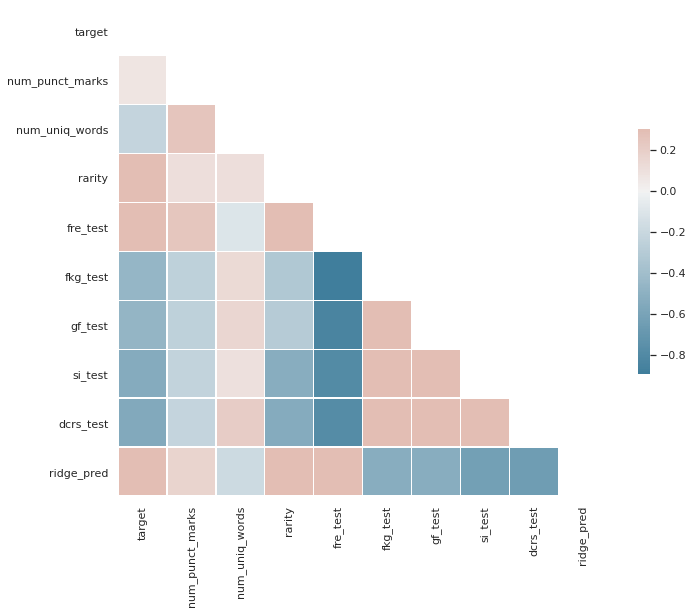

In [25]:
# setting plot style
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

???
#### If we look the target column we can se that there aren't any strong correlations. 
* The strongest is with the dcrs_test, corr=-0.54, 
* the second with out benchmark the fre_test, corr=0.51
* third our rarity index, corr=0.45

#### Let's plot the distributions of this 4 variables:

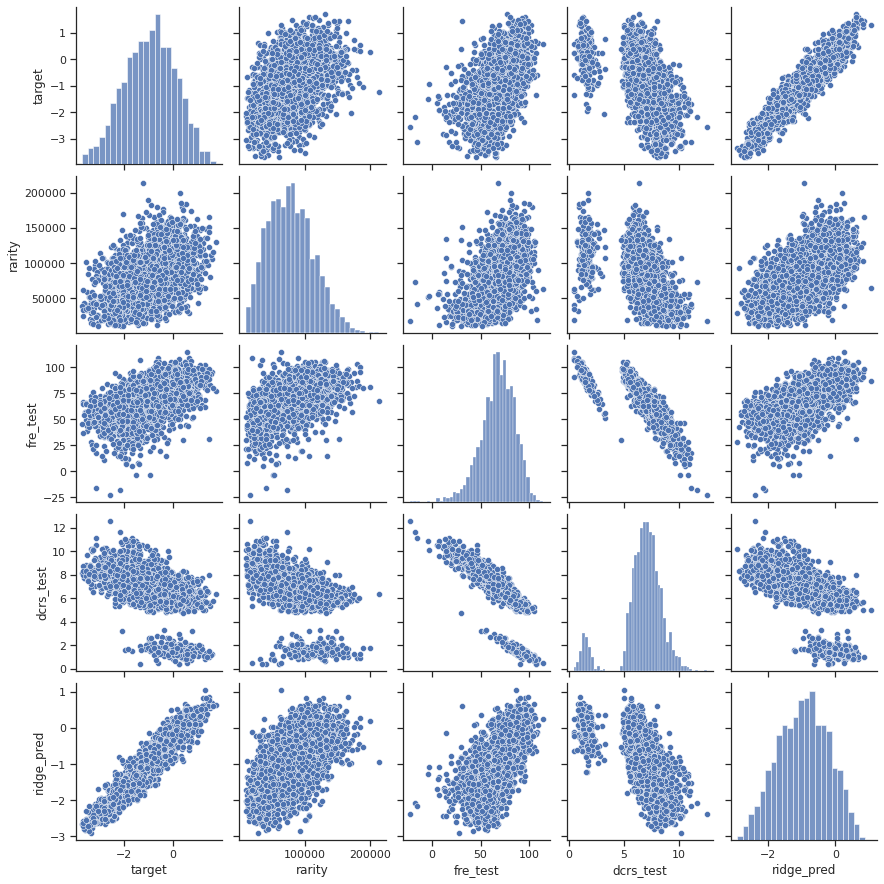

In [27]:
sns.set_theme(style="ticks")
sns.pairplot(train[['target', 'rarity', 'fre_test', 'dcrs_test', 'ridge_pred']])

#### Triying with different models in search of good results:

In [28]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
# for results
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [49]:
# This validation set will be useful to select the best model.
validation = pd.read_csv('validation.csv', usecols=['id', 'excerpt', 'target'])
add_creative_features(validation)
add_clasic_test(validation)

X_validation = validation['excerpt']
Y_validation = validation['target']

preds = pipeline.predict(X_validation)
validation['ridge_pred'] = preds

In [54]:
variables = ['fre_test', 'dcrs_test', 'ridge_pred']

# training:
X_train = train[variables].values

regr = SVR()
regr.fit(X_train, Y_train)

X_test = validation[variables].values
X_test_pred = regr.predict(X_test)

# R2:
print(f'{var} vs target... R2: {round(regr.score(X_test, Y_validation), 3)}')
# MAE:
print(f'{var} vs target... MAE: {round(mean_absolute_error(Y_validation, X_test_pred), 3)}')
# RMSE:
print(f'{var} vs target... RMSE: {round(math.sqrt(mean_squared_error(Y_validation, X_test_pred)), 3)}', '\n')

ridge_pred vs target... R2: 0.5
ridge_pred vs target... MAE: 0.574
ridge_pred vs target... RMSE: 0.72 



### Let's try to clasify the excerpt first

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [21]:
# All relevant features
Y_train = train['is_hard'].values
Y_test = test['is_hard'].values

variables = ['fre_test', 'rarity', 'punctuation_marks', 'num_diff_words',
             'fkg_test', 'gf_test', 'si_test', 'dcrs_test']

X_train = train[variables].values

for method_func in [SVC, LogisticRegression, KNeighborsClassifier, MLPClassifier,
                    GaussianProcessClassifier, DecisionTreeClassifier,
                    GradientBoostingClassifier, AdaBoostClassifier,
                    RandomForestClassifier]:
    clsf = method_func()
    clsf.fit(X_train, Y_train)

    X_test = test[variables].values

    # Accuracy:
    print(f'{method_func.__name__} predicting is_hard... %: {round(clsf.score(X_train, Y_train), 3)}')
    print(f'{method_func.__name__} predicting is_hard... %: {round(clsf.score(X_test, Y_test), 3)}', '\n')    

KeyError: 'is_hard'